# Binned plots for the observations climatology
New/updated versions for the paper using **Tb - cpT** instead of just Tb to do the binning

Changed from qi to IWC; comment out to switch back

In [2]:
import sys
sys.path.append("/home/b/b380887/cold-point-overshoot/python_scripts")
import pickle

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import tol_colors as tc
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
import bin_obs_overshoot as boo

from matplotlib.gridspec import GridSpec
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [3]:
year_list = [2007, 2008, 2009, 2010]
season_list = ["DJF", "JJA"]
region_dict = {
    "DJF": ["AMZ", "SPC", "IOS", "ECP"],
    "JJA": ["AFR", "WPC", "IOE", "ECP"]
}

years_sorted = list(sorted(year_list))
years_str = str(years_sorted[0]) + "-" + str(years_sorted[-1])
print(years_str)


2007-2010


In [4]:
coords_dict = {
    "ECP": [-150, -100, 0, 15],
    "ECP2": [-150, -100, 0, 15], # repeated
    "WPC": [130, 180, 0, 15],
    "AFR": [-7, 35, 0, 18],
    "IOE": [53, 95, -12, 6],
    "AMZ": [-72, -47, -30, 0],
    "SPC": [165, -145, -20, -5],
    "IOS": [50, 100, -15, 0]
}

In [5]:
pickle_dir_hist = "/home/b/b380887/cold-point-overshoot/pickle_files/obs_tb-cpt_hists/"
pickle_dir_bin = "/home/b/b380887/cold-point-overshoot/pickle_files/binned_by_tb/Tb_minus_cpT/"
file_path = "/work/bb1153/b380887/big_obs_climo/"

# set to true if you haven't made binned dicts for all years yet
save_dicts = False


## Make or read in the dictionaries
Bins all years in each region (individual years were already made)

In [6]:
def get_binned_data_all_years(season, region_dict, year_list, file_path=file_path):
    """ Get cold point-relative dardar and (Tb - cpT) for all years for one season
    """
    diffs_dar_dict = {}
    ds_dar_dict = {}

    region_list = region_dict[season]

    for region in region_list:
        diffs_dar_list = [[]]*len(year_list)
        
        if region == "SPC":
            ds_dar_list = [[]]*len(year_list)
            for i, year in enumerate(year_list):
                ds_dar_1, tb_1, cpT_ri_1 = boo.get_data(season, year, "SPC1", file_path, bin_by_diffs=True)
                ds_dar_2, tb_2, cpT_ri_2 = boo.get_data(season, year, "SPC2", file_path, bin_by_diffs=True)

                tb_dar_1 = tb_1.sel(time=ds_dar_1["iwc_cp"].time, lat=ds_dar_1["iwc_cp"].lat, lon=ds_dar_1["iwc_cp"].lon, method="nearest")
                cpT_ri_dar_1 = cpT_ri_1.sel(time=ds_dar_1["iwc_cp"].time, lat=ds_dar_1["iwc_cp"].lat, lon=ds_dar_1["iwc_cp"].lon, method="nearest")
                tb_dar_2 = tb_2.sel(time=ds_dar_2["iwc_cp"].time, lat=ds_dar_2["iwc_cp"].lat, lon=ds_dar_2["iwc_cp"].lon, method="nearest")
                cpT_ri_dar_2 = cpT_ri_2.sel(time=ds_dar_2["iwc_cp"].time, lat=ds_dar_2["iwc_cp"].lat, lon=ds_dar_2["iwc_cp"].lon, method="nearest")

                diffs_dar_1 = xr.DataArray(
                    (tb_dar_1.values - cpT_ri_dar_1.values),
                    dims=["time"],
                    coords={"time": ds_dar_1["iwc_cp"].time}
                )
                diffs_dar_2 = xr.DataArray(
                    (tb_dar_2.values - cpT_ri_dar_2.values),
                    dims=["time"],
                    coords={"time": ds_dar_2["iwc_cp"].time}
                )

                ds_dar_list[i] = xr.concat([ds_dar_1, ds_dar_2], dim="time")
                diffs_dar_list[i] = xr.concat([diffs_dar_1, diffs_dar_2], dim="time")
                print(region, year, "done")
        else:
            output_list = [
                boo.get_data(season, year, region, file_path, bin_by_diffs=True)
                for year in year_list
            ]
            ds_dar_list = [output_list[i][0] for i in range(len(output_list))]
            tb_list = [output_list[i][1] for i in range(len(output_list))]
            cpT_ri_list = [output_list[i][2] for i in range(len(output_list))]

            for i, ds_dar in enumerate(ds_dar_list):
                iwc = ds_dar["iwc_cp"]
                tb_dar = tb_list[i].sel(time=iwc.time, lat=iwc.lat, lon=iwc.lon, method="nearest")
                cpT_ri_dar = cpT_ri_list[i].sel(time=iwc.time, lat=iwc.lat, lon=iwc.lon, method="nearest")
                diffs_dar_vals = tb_dar.values - cpT_ri_dar.values
                diffs_dar = xr.DataArray(diffs_dar_vals, dims=["time"], coords={"time": iwc.time})
                diffs_dar_list[i] = diffs_dar

        diffs_dar_dict[region] = xr.concat(diffs_dar_list, dim="time")
        ds_dar_dict[region] = xr.concat(ds_dar_list, dim="time")
        print(region, "done")
        
    return [diffs_dar_dict, ds_dar_dict]


In [17]:
pickle_dir_bin

'/home/b/b380887/cold-point-overshoot/pickle_files/racp_cirrus_binned/'

In [6]:
def save_binned_data_all_years(season, region_dict, dar_dict, diffs_dict, years_str=years_str,
                              file_path=file_path, pickle_dir=pickle_dir_bin):
    """ Save the dictionaries of iwc binned by (Tb-cpT) for all years in a season
    """
    for region in region_dict[season]:
#         output_qi = boo.bin_var_by_diffs(dar_dict[region], diffs_dict[region], "qi", 
#                                       save_dicts=True, pickle_dir=pickle_dir,
#                                       month=season, year=years_str, region=region) 
        output_iwc = boo.bin_var_by_diffs(dar_dict[region], diffs_dict[region], "iwc", 
                                      save_dicts=True, pickle_dir=pickle_dir,
                                      month=season, year=years_str, region=region) 
        output_re = boo.bin_var_by_diffs(dar_dict[region], diffs_dict[region], "Re", save_dicts=True, pickle_dir=pickle_dir,
                                   month=season, year=years_str, region=region, iflag=3)
#         output_qi3 = boo.bin_var_by_diffs(dar_dict[region], diffs_dict[region], "qi", save_dicts=True, pickle_dir=pickle_dir,
#                                        month=season, year=years_str, region=region, iflag=3)
        output_iwc3 = boo.bin_var_by_diffs(dar_dict[region], diffs_dict[region], "iwc", save_dicts=True, pickle_dir=pickle_dir,
                                       month=season, year=years_str, region=region, iflag=3)
        print(region, "done")


### Make & save the binned dicts if needed

In [7]:
%%time
if save_dicts:
    diffs_dict_djf, ds_dar_dict_djf = get_binned_data_all_years("DJF", region_dict, year_list,
                                                               file_path=file_path+"DJF/")
    save_binned_data_all_years("DJF", region_dict, ds_dar_dict_djf, diffs_dict_djf)
    print("DJF done\n\n")
    
    diffs_dict_jja, ds_dar_dict_jja = get_binned_data_all_years("JJA", region_dict, year_list,
                                                               file_path=file_path+"JJA/")
    save_binned_data_all_years("JJA", region_dict, ds_dar_dict_jja, diffs_dict_jja)
    print("JJA done")
    

AMZ done
SPC 2007 done
SPC 2008 done
SPC 2009 done
SPC 2010 done
SPC done
IOS done
ECP done
AMZ done
SPC done
IOS done
ECP done
DJF done


AFR done
WPC done
IOE done
ECP done
AFR done
WPC done
IOE done
ECP done
JJA done
CPU times: user 17.9 s, sys: 33.1 s, total: 51 s
Wall time: 17min 46s


### Load in the saved dicts

In [7]:
# empty dictionaries
region_diffs_counts_dict_djf = {}
# qi_means_dict_djf = {}
# qi_counts_dict_djf = {}
# qi3_means_dict_djf = {}
# qi3_counts_dict_djf = {}
iwc_means_dict_djf = {}
iwc_counts_dict_djf = {}
iwc3_means_dict_djf = {}
iwc3_counts_dict_djf = {}

region_diffs_counts_dict_jja = {}
# qi_means_dict_jja = {}
# qi_counts_dict_jja = {}
# qi3_means_dict_jja = {}
# qi3_counts_dict_jja = {}
iwc_means_dict_jja = {}
iwc_counts_dict_jja = {}
iwc3_means_dict_jja = {}
iwc3_counts_dict_jja = {}

for region in region_dict["DJF"]:
    with open(pickle_dir_hist + "Tb-cpT_histogram_dict_{s}{y}_{r}.pickle".format(r=region, y=years_str, s="DJF"), "rb") as handle:
        diffs_count_dict = pickle.load(handle)
    region_diffs_counts_dict_djf[region] = diffs_count_dict["counts"]

    # qi_means_dict_djf[region], qi_counts_dict_djf[region] = boo.load_saved_dicts("qi", "DJF", region, years_str, pickle_dir_bin)
    # qi3_means_dict_djf[region], qi3_counts_dict_djf[region] = boo.load_saved_dicts("qi", "DJF", region, years_str, pickle_dir_bin, iflag=3)
    iwc_means_dict_djf[region], iwc_counts_dict_djf[region] = boo.load_saved_dicts("iwc", "DJF", region, years_str, pickle_dir_bin)
    iwc3_means_dict_djf[region], iwc3_counts_dict_djf[region] = boo.load_saved_dicts("iwc", "DJF", region, years_str, pickle_dir_bin, iflag=3)

for region in region_dict["JJA"]:
    with open(pickle_dir_hist + "Tb-cpT_histogram_dict_{s}{y}_{r}.pickle".format(r=region, y=years_str, s="JJA"), "rb") as handle:
        diffs_count_dict = pickle.load(handle)
    region_diffs_counts_dict_jja[region] = diffs_count_dict["counts"]

    # qi_means_dict_jja[region], qi_counts_dict_jja[region] = boo.load_saved_dicts("qi", "JJA", region, years_str, pickle_dir_bin)
    # qi3_means_dict_jja[region], qi3_counts_dict_jja[region] = boo.load_saved_dicts("qi", "JJA", region, years_str, pickle_dir_bin, iflag=3)
    iwc_means_dict_jja[region], iwc_counts_dict_jja[region] = boo.load_saved_dicts("iwc", "JJA", region, years_str, pickle_dir_bin)
    iwc3_means_dict_jja[region], iwc3_counts_dict_jja[region] = boo.load_saved_dicts("iwc", "JJA", region, years_str, pickle_dir_bin, iflag=3)


In [40]:
region = "SPC"

In [41]:
iwc_a500_counts = iwc_counts_dict_djf[region]["1"]
iwc3_a500_counts = iwc3_counts_dict_djf[region]["1"]
bin_counts = region_diffs_counts_dict_djf[region]

## Make the plots

#### All retrievals

In [8]:
def map_subplot(axis, coords, projection, labsize, hide_lats=False, panel_width=100,
                panel_height=60, xrot=0, lw=8, dx=20, dy=15, lat_min=-30, tick_len=14):
    """ Code to plot a map of one region on an axis
    """
    # change to (0 --> 360) if it crosses the dateline
    if coords[1] < coords[0]:
        lon_min = coords[0] % 360
        lon_max = coords[1] % 360
    else:
        lon_min = coords[0]
        lon_max = coords[1]

    rect_width = lon_max - lon_min
    rect_height = coords[3] - coords[2]
    xdiff = (panel_width - rect_width)/2
    
    bottom = lat_min
    top = lat_min + panel_height
    left = 5*round((lon_min - xdiff)/5)
    right = 5*round((lon_max + xdiff)/5)
    extent = [left, right, bottom, top]

    axis.add_feature(cfeature.COASTLINE, linewidth=2)
    axis.stock_img() # this works, but not stamen terrain

    # gridlines and axis labels
    ylocs = np.arange(bottom, top+1, dy) 
    if right > 180:
        left_180 = (left + 180) % 360 - 180
        right_180 = (right + 180) % 360 - 180
        pos_locs = np.arange(left_180, 180, dx)
        neg_left = (pos_locs[-1] + dx) - 360
        neg_locs = np.arange(neg_left, right_180+1, dx)
        xlocs = [
            *pos_locs,
            *neg_locs
        ]
    else:
        xlocs = np.arange(left, right+1, dx)
    gl = axis.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                        xlocs=xlocs, ylocs=ylocs, 
                        linewidth=2, color='k', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': labsize, 'rotation': xrot}
    gl.ylabel_style = {'size': labsize}


    # add region borders
    axis.add_patch(mpatches.Rectangle(xy=[coords[0], coords[2]], 
                              width=rect_width,
                              height=rect_height,
                              fill=False, color='k', linewidth=lw,
                              transform=ccrs.PlateCarree(), zorder=10
                             ))

    axis.set_extent(extent, crs=ccrs.PlateCarree(central_longitude=0))


In [9]:
def bin_qi_season(means_dict, counts_dict, region_diffs_counts_dict, season, years_str, bins,  mean_lims=(1e-6, 5e-4),
                  coords_dict=coords_dict, fsize=26, tsize=30, labsize=24, figsize=(33, 18), diffs_count_lims=(1, 1000),
                  diffs_lims=None, count_cmap="Spectral", mean_cmap="PiYG", save=False, save_dir=None, show_maps=True, main_text=True,
                  bin_iwc=False, mean_norm=None, count_norm=None, count_cbar_ticks=None, mean_cbar_ticks=None, cmap_version=""): 

    """
    Plot DARDAR qi (or IWC, if bin_iwc=True) values binned by MERGIR brightness temperatures at levels relative to the cold 
    point. Variable "statistic" is "count" or "mean". Plots the Tb bin count at the bottom instead of
    the -1000m level.
    """
    regions = list(region_diffs_counts_dict.keys())
    if bin_iwc:
        long_name = "IWC"
        units = "kg/m$^3$"
    else:
        long_name = "cloud ice"
        units = "kg/kg"
    
    ind_offsets = [-2, -1, 0, 1, 2]
    offset_labs = [
        "$T_b-T_{CP}$\nbin counts",
        "-500 m",
        "Cold point",
        "+500 m",
        "+1000 m"
    ]
    
    
    # set up figure
    fig = plt.figure(figsize=figsize)
    if show_maps:
        gs = GridSpec(5, 21, figure=fig, height_ratios=[0.25, 3, 4, 5, 0.75], hspace=0.7, wspace=0.5)
        projection = ccrs.PlateCarree(central_longitude=180)
    else:
        gs = GridSpec(4, 21, figure=fig, height_ratios=[0.25, 4, 5, 0.75], hspace=0.7, wspace=0.5)

    if len(season) == 2:
        ax_title_left = fig.add_subplot(gs[0, :10])
        ax_title_right = fig.add_subplot(gs[0, 10:20])
    else:
        ax_title = fig.add_subplot(gs[0, :20])
        
    if show_maps:
        # different projection for land (center on 0, not 180)
        if regions[0] == "AFR" or regions[0] == "AMZ":
            proj_0 = ccrs.PlateCarree(central_longitude=0)
        else:
            proj_0 = ccrs.PlateCarree(central_longitude=180)
        if regions[2] == "AFR" or regions[2] == "AMZ":
            proj_2 = ccrs.PlateCarree(central_longitude=0)
        else:
            proj_2 = ccrs.PlateCarree(central_longitude=180)
        map_axes = [
            fig.add_subplot(gs[1, :5], projection=proj_0),
            fig.add_subplot(gs[1, 5:10], projection=projection),
            fig.add_subplot(gs[1, 10:15], projection=proj_2),
            fig.add_subplot(gs[1, 15:20], projection=projection),
        ]
        mean_axes = [
            fig.add_subplot(gs[2, :5]),
            fig.add_subplot(gs[2, 5:10]),
            fig.add_subplot(gs[2, 10:15]),
            fig.add_subplot(gs[2, 15:20]),
        ]
        count_axes = [
            fig.add_subplot(gs[3, :5]),
            fig.add_subplot(gs[3, 5:10]),
            fig.add_subplot(gs[3, 10:15]),
            fig.add_subplot(gs[3, 15:20]),
        ]
        cbar_axes = [
            fig.add_subplot(gs[4, 2:9]),
            fig.add_subplot(gs[4, 12:19]),
        ]
    else:
        mean_axes = [
            fig.add_subplot(gs[1, :5]),
            fig.add_subplot(gs[1, 5:10]),
            fig.add_subplot(gs[1, 10:15]),
            fig.add_subplot(gs[1, 15:20]),
        ]
        count_axes = [
            fig.add_subplot(gs[2, :5]),
            fig.add_subplot(gs[2, 5:10]),
            fig.add_subplot(gs[2, 10:15]),
            fig.add_subplot(gs[2, 15:20]),
        ]
        cbar_axes = [
            fig.add_subplot(gs[3, 2:9]),
            fig.add_subplot(gs[3, 12:19]),
        ]
        
    # plot 
    bin_mean_values = (bins[:-1] + bins[1:])/2
    for i, region in enumerate(regions):
        bin_mean_dict = means_dict[region]
        bin_count_dict = counts_dict[region]
        diffs_counts = region_diffs_counts_dict[region]
        if show_maps:
            ax_map = map_axes[i]
        ax_mean = mean_axes[i]
        ax_count = count_axes[i]

        # turn the values into arrays
        bin_mean_dict_arr = np.array(list(bin_mean_dict.values()))[1:, :]
        bin_count_dict_arr = np.array(list(bin_count_dict.values()))[1:, :]
        tiled_counts = np.zeros((len(ind_offsets), len(diffs_counts)))
        tiled_counts[0, :] = diffs_counts
        tiled_counts[1:, :] = np.nan
        
        # plot map
        if show_maps:
            if region == "ECP2":
                region_txt = "ECP"
            else:
                region_txt = region
            ax_map.set_title(region_txt, fontsize=tsize)
            if i == 0:
                map_subplot(ax_map, coords_dict[region], proj_0, labsize=fsize-5, xrot=20, panel_width=125, dy=15, dx=25)
            elif i == 2:
                map_subplot(ax_map, coords_dict[region], proj_2, labsize=fsize-5, xrot=20, panel_width=125, dy=15, dx=25)
            else:
                map_subplot(ax_map, coords_dict[region], projection, labsize=fsize-5, xrot=20, panel_width=125, dy=15, dx=25)

        # plot bin means
        if mean_norm is None:
            mean_norm = mcolors.LogNorm(vmin=mean_lims[0], vmax=mean_lims[1])
        pcm1 = ax_mean.pcolormesh(bin_mean_values, ind_offsets[1:], bin_mean_dict_arr, cmap=mean_cmap, norm=mean_norm)
        
        # plot bin counts
        if count_norm is None:
            count_norm = mcolors.LogNorm(vmin=diffs_count_lims[0], vmax=diffs_count_lims[1])
        pcm_c1 = ax_count.pcolormesh(bin_mean_values, ind_offsets[1:], bin_count_dict_arr, cmap=count_cmap,
                                     norm=count_norm)
        pcm_c2 = ax_count.pcolormesh(bin_mean_values, ind_offsets, tiled_counts,
                      cmap=count_cmap, norm=count_norm)
        
        # format axes (all)
        for ax in [ax_mean, ax_count]:
            ax.tick_params(axis="y", labelsize=fsize-5, length=0)
            ax.set_xticks(bins[::4])        
            ax.tick_params(axis="x", rotation=45, labelsize=labsize+5)
            ax.tick_params(axis="y", labelsize=labsize)
            ax.xaxis.set_minor_locator(mticker.MultipleLocator(2))
            ax.xaxis.set_major_locator(mticker.MultipleLocator(10))
            ax.tick_params(which='minor', length=10)
            ax.tick_params(which='major', length=14)
            if diffs_lims is not None:
                ax.set_xlim(diffs_lims[0], diffs_lims[-1])
        
        # titles for clarity
        ax_mean.set_title("Bin-mean {n}".format(n=long_name), fontsize=fsize)
        ax_count.set_title("Bin counts", fontsize=fsize)

        # add horizontal borders
        for ind in ind_offsets[:-1]:
            gap = 0.5
            ax_mean.axhline(ind+0.5, color="k", linewidth=2)
            if ind == -2:
                ax_count.axhline(ind+0.5, color="k", linewidth=10)
            else:
                ax_count.axhline(ind+0.5, color="k", linewidth=2)
                
        # add zero lines
        ax_mean.axvline(0, color="k", linewidth=5, dashes=[4, 2])
        ax_count.axvline(0, color="k", linewidth=5, dashes=[4, 2])

        # only y tick labels on left subplots
        if i == 0:
            ax_mean.set_yticks(ind_offsets[1:])
            ax_mean.set_yticklabels(offset_labs[1:], fontsize=fsize-5)
            ax_count.set_yticks(ind_offsets)
            ax_count.set_yticklabels(offset_labs, fontsize=fsize-5)
        else:
            ax_count.set_yticks(ind_offsets)
            ax_count.set_yticklabels([""]*len(ind_offsets))
            ax_mean.set_yticks(ind_offsets[1:])
            ax_mean.set_yticklabels([""]*(len(ind_offsets)-1))

        # only x axis labels on bottom subplots
        ax_count.set_xlabel("$T_b - T_{CP}$ (K)", fontsize=fsize)
        
    # scientific notation for colorbar ticks
    def sci_fmt(x, pos):
        a, b = '{:.0e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)
    def sci_fmt_2(x, pos):
        a, b = '{:.0e}'.format(x).split('e')
        b = int(b)
        return r'$10^{{{}}}$'.format(b)
    
    # bin mean colorbar
    axins1 = inset_axes(cbar_axes[0], width="100%", height="80%", loc='center')
    cbar_axes[0].axis("off")
    if mean_cbar_ticks is not None:
        cb1 = plt.colorbar(pcm1, cax=axins1, extend="max", orientation="horizontal", ticks=mean_cbar_ticks)#, format=mticker.FuncFormatter(sci_fmt))
    else:
        cb1 = plt.colorbar(pcm1, cax=axins1, extend="max", orientation="horizontal")#, format=mticker.FuncFormatter(sci_fmt))
    cb1.ax.tick_params(labelsize=fsize)
    cb1.set_label("Bin-mean {n} ({u})".format(n=long_name, u=units), fontsize=fsize+5)
    cb1.ax.tick_params(which='minor', length=10)
    cb1.ax.tick_params(which='major', length=14, rotation=0) #0)     
    
    # count colorbar
    axins2 = inset_axes(cbar_axes[1], width="100%", height="80%", loc='center')
    cbar_axes[1].axis("off")
    if count_cbar_ticks is not None:
        cb2 = plt.colorbar(pcm_c2, cax=axins2, extend="max", orientation="horizontal", ticks=count_cbar_ticks)
    else:
        cb2 = plt.colorbar(pcm_c2, cax=axins2, extend="max", orientation="horizontal")
    cb2.ax.tick_params(labelsize=fsize)
    cb2.set_label("Bin counts", fontsize=fsize+5)
    cb2.ax.tick_params(which='minor', length=10)
    cb2.ax.tick_params(which='major', length=14, rotation=0) #0) 
    
    # title
    if len(season) == 2:
        ax_title_left.axis("off")
        ax_title_left.text(x=0.5, y=0, s="{s} {y}".format(s=season[0], y=years_str.replace("-", "—")), verticalalignment="center",
                      horizontalalignment="center", fontsize=tsize+5
                      )
        ax_title_right.axis("off")
        ax_title_right.text(x=0.5, y=0, s="{s} {y}".format(s=season[1], y=years_str.replace("-", "—")), verticalalignment="center",
                      horizontalalignment="center", fontsize=tsize+5
                      )
    else:
        ax_title.axis("off")
        ax_title.text(x=0.5, y=0, s="{s} {y}".format(s=season, y=years_str.replace("-", "—")), verticalalignment="center",
                      horizontalalignment="center", fontsize=tsize+5
                      )

    if save:
        if save_dir is None:
            raise Exception("Must provide save_dir if you want to save the plot")
        if len(season) == 2:
            type_str = "both_instr_"
        else:
            type_str = "all_"
       
        if bin_iwc:
            varname = "IWC"
        else:
            varname = "qi"
  
        if main_text:
            fig_name = save_dir + "{v}_binned_by_Tb-Tcp_{t}_main_text{c}.png".format(v=varname, t=type_str, c=cmap_version)
        else:
            fig_name = save_dir + "{v}_binned_by_Tb-Tcp_{t}_SI{c}.png".format(v=varname, t=type_str, c=cmap_version)
        
        print("saved to", fig_name)
        plt.savefig(fig_name, dpi=300, bbox_inches="tight")

    plt.show()
    

In [10]:
save_plots = True
plot_save_dir = "/home/b/b380887/cold-point-overshoot/plots/obs_paper/paper_figs/"

diffs_bins = np.arange(-20, 101, 2)
diffs_lims = (-10, 100)

# qi_lims = (1e-6, 1e-3)
iwc_lims = (1e-7, 1e-4)
count_lims=(1, 1e5)
figsize = (60, 33)

fsize = 45
tsize = 60
labsize = 30



In [11]:
# from the tol iridescent colormap
count_colors = [
    # "#FEFBE9",
    "#FCF7D5",
    "#F5F3C1",
    "#EAF0B5",
    "#DDECBF",
    "#D0E7CA",
    "#C2E3D2",
    "#B5DDD8",
    "#A8D8DC",
    "#9BD2E1",
    "#8DCBE4",
    "#81C4E7",
    "#7BBCE7",
    "#7EB2E4",
    "#88A5DD",
    "#9398D2",
    "#9B8AC4",
    "#9D7DB2",
    "#9A709E",
    "#906388",
    "#805770",
    "#684957",
    # "#46353A"
]
count_cmap = mcolors.ListedColormap(count_colors)
count_norm = None 


In [15]:
# from tol rainbow_discrete
mean_colors = [
    "#e8ecfb",
    "#e1dcef",
    "#d9cce3",
    "#caaccb",
    "#ba8db4",
    "#ab6f9e",
    "#994f88",
    "#882e72",
    "#514a91",
    "#1866b0",
    "#437dbf",
    "#6195cf",
    "#7bafde",
    "#41967d",
    "#4eb265",
    "#90c987",
    "#cae0ab",
    "#e1e881",
    "#f7f057",
    "#f7d94d",
    "#f7cb46",
    "#f4a735",
    "#ef8026",
    "#e65518",
    "#dc050d",
    "#a5180e",
    "#72190e",
    "#42150b"
]
mean_cmap = mcolors.ListedColormap(mean_colors)
mean_norm = None


### New version

Based on rainbow discrete, without levels specified (so normal log norm...) - for BOTH!

"version 11" from testing different colormaps

saved to /home/b/b380887/cold-point-overshoot/plots/obs_paper/paper_figs/IWC_binned_by_Tb-Tcp_all__main_text_11.png


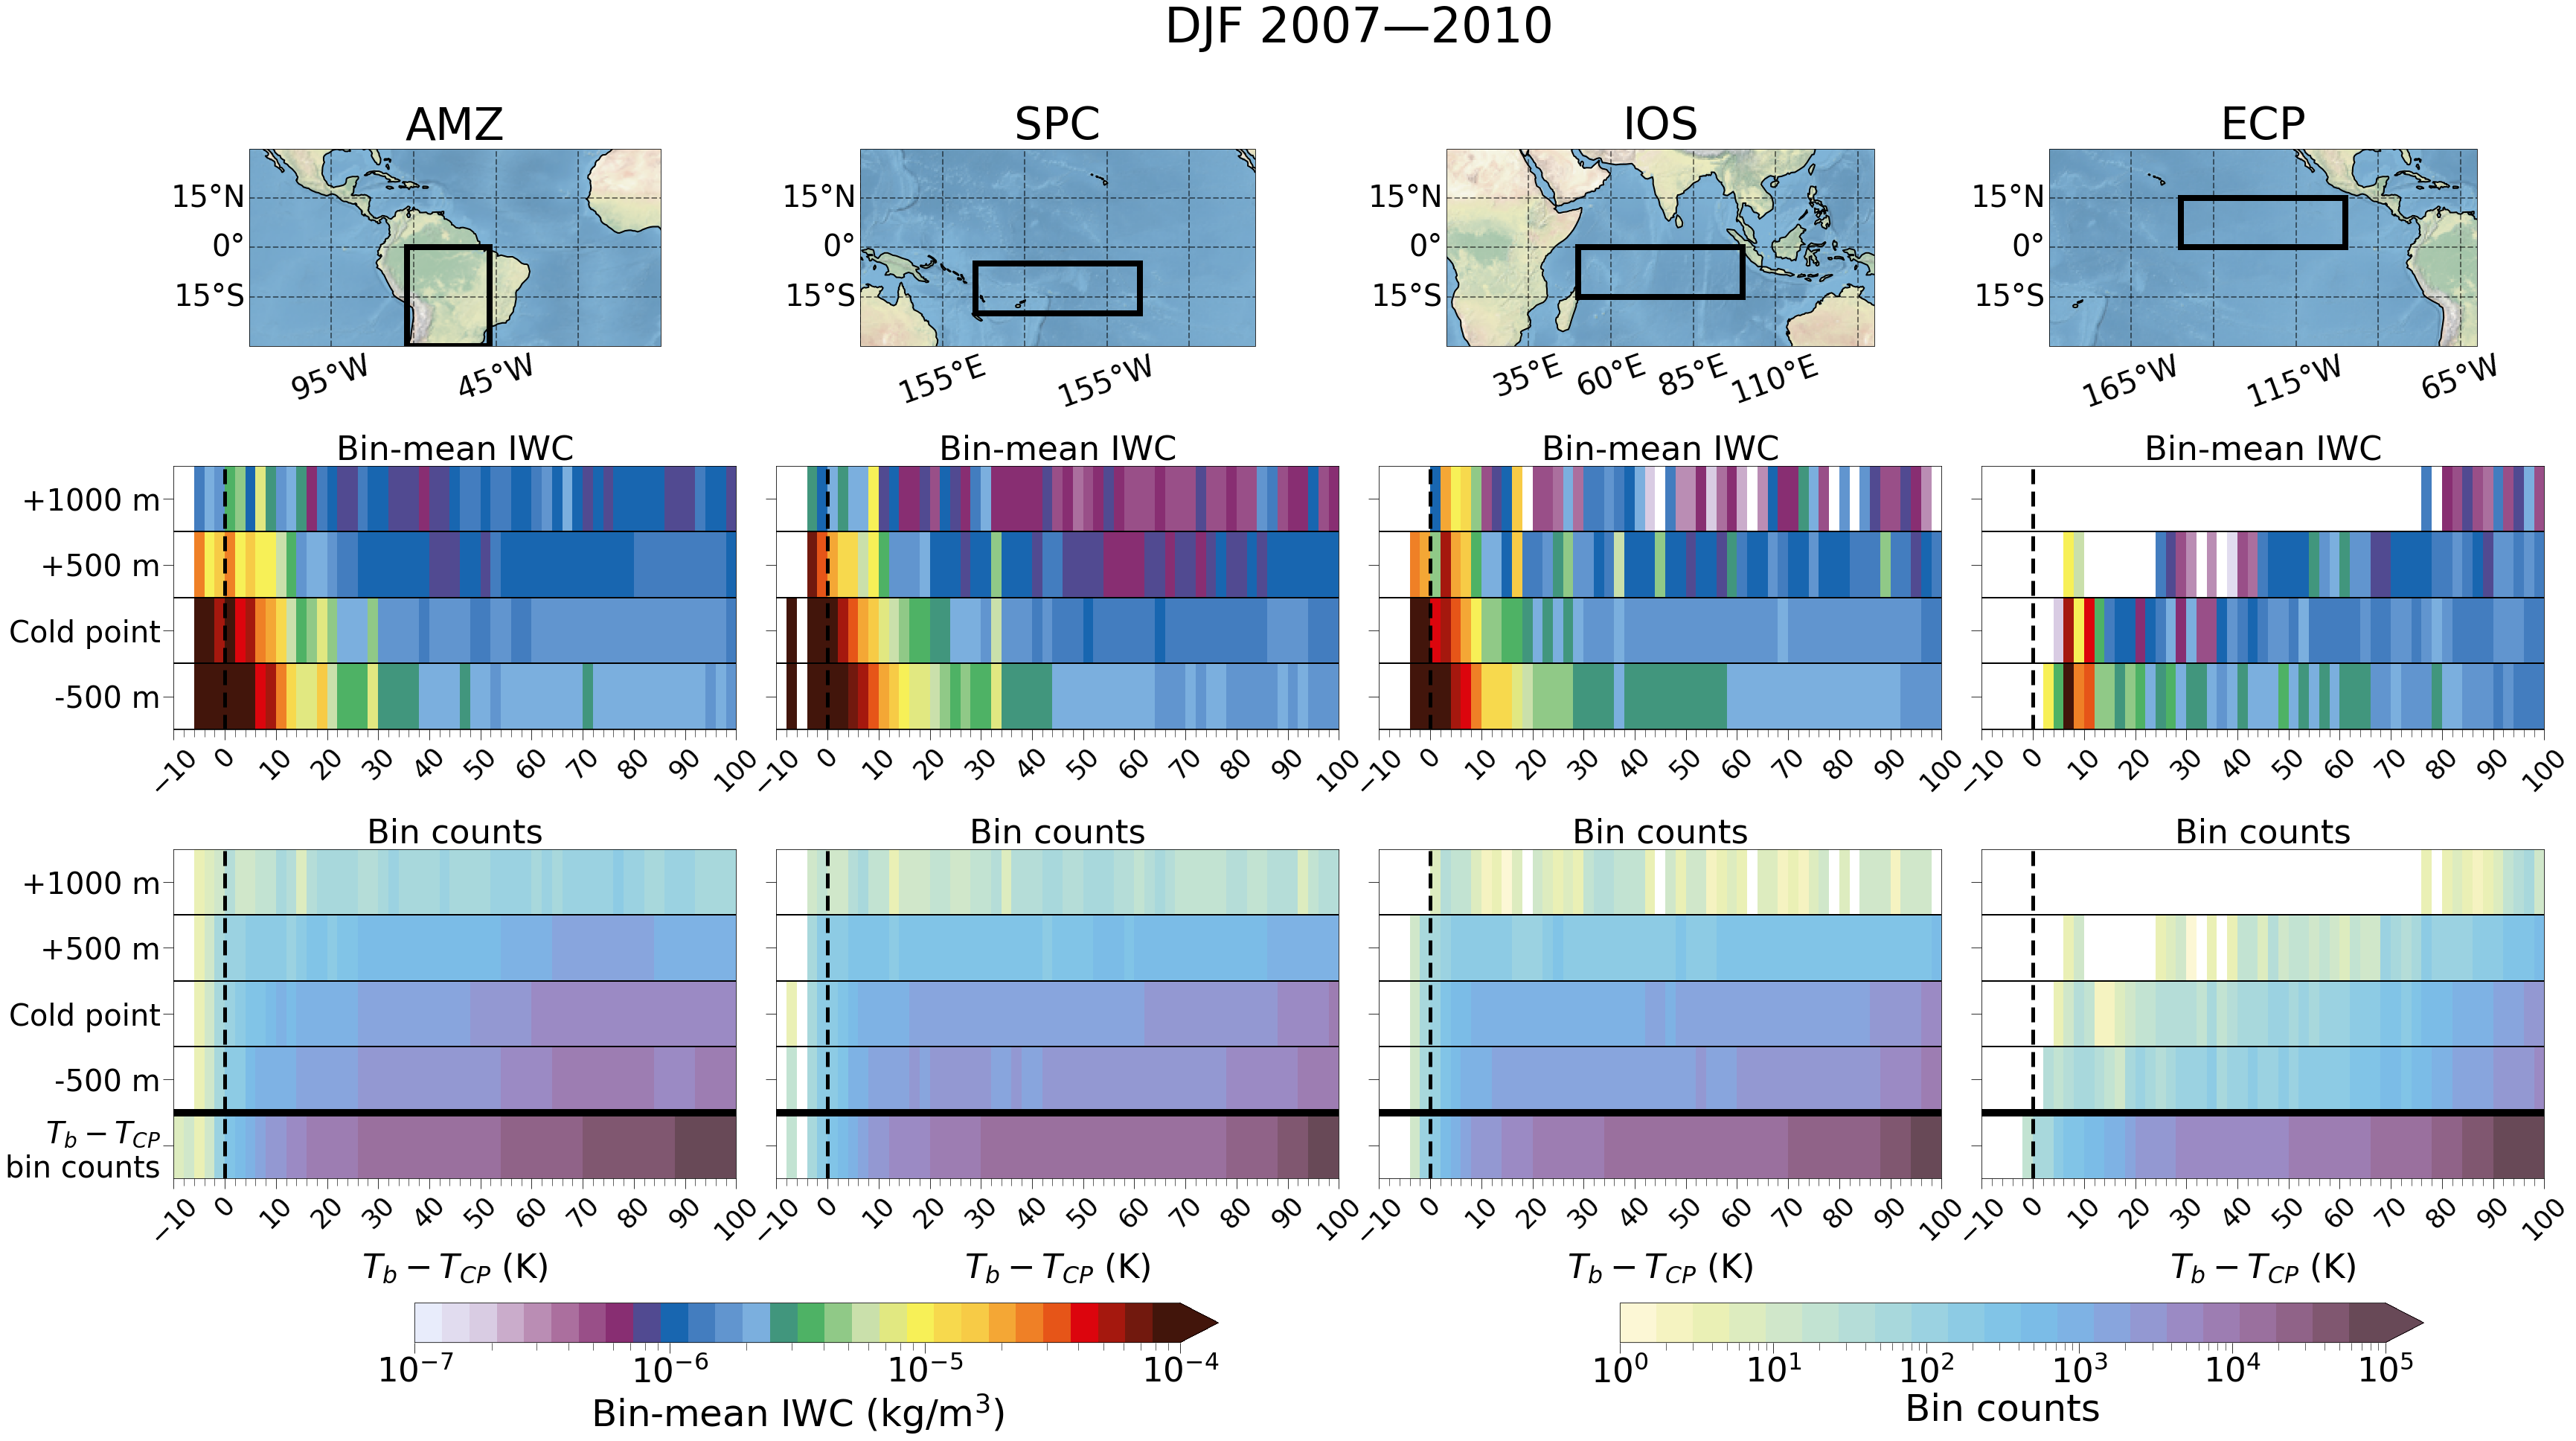

In [16]:
# DJF (main text)
bin_qi_season(iwc_means_dict_djf, iwc_counts_dict_djf, region_diffs_counts_dict_djf, "DJF", years_str, diffs_bins, 
              bin_iwc=True, mean_lims=iwc_lims,
              fsize=fsize, tsize=tsize, labsize=labsize, figsize=figsize, diffs_count_lims=count_lims,
              diffs_lims=diffs_lims, count_cmap=count_cmap, mean_cmap=mean_cmap, 
              save=save_plots, save_dir=plot_save_dir, main_text=True, cmap_version="_11",
              count_norm=None, mean_norm=None, count_cbar_ticks=None)


saved to /home/b/b380887/cold-point-overshoot/plots/obs_paper/paper_figs/IWC_binned_by_Tb-Tcp_all__SI_11.png


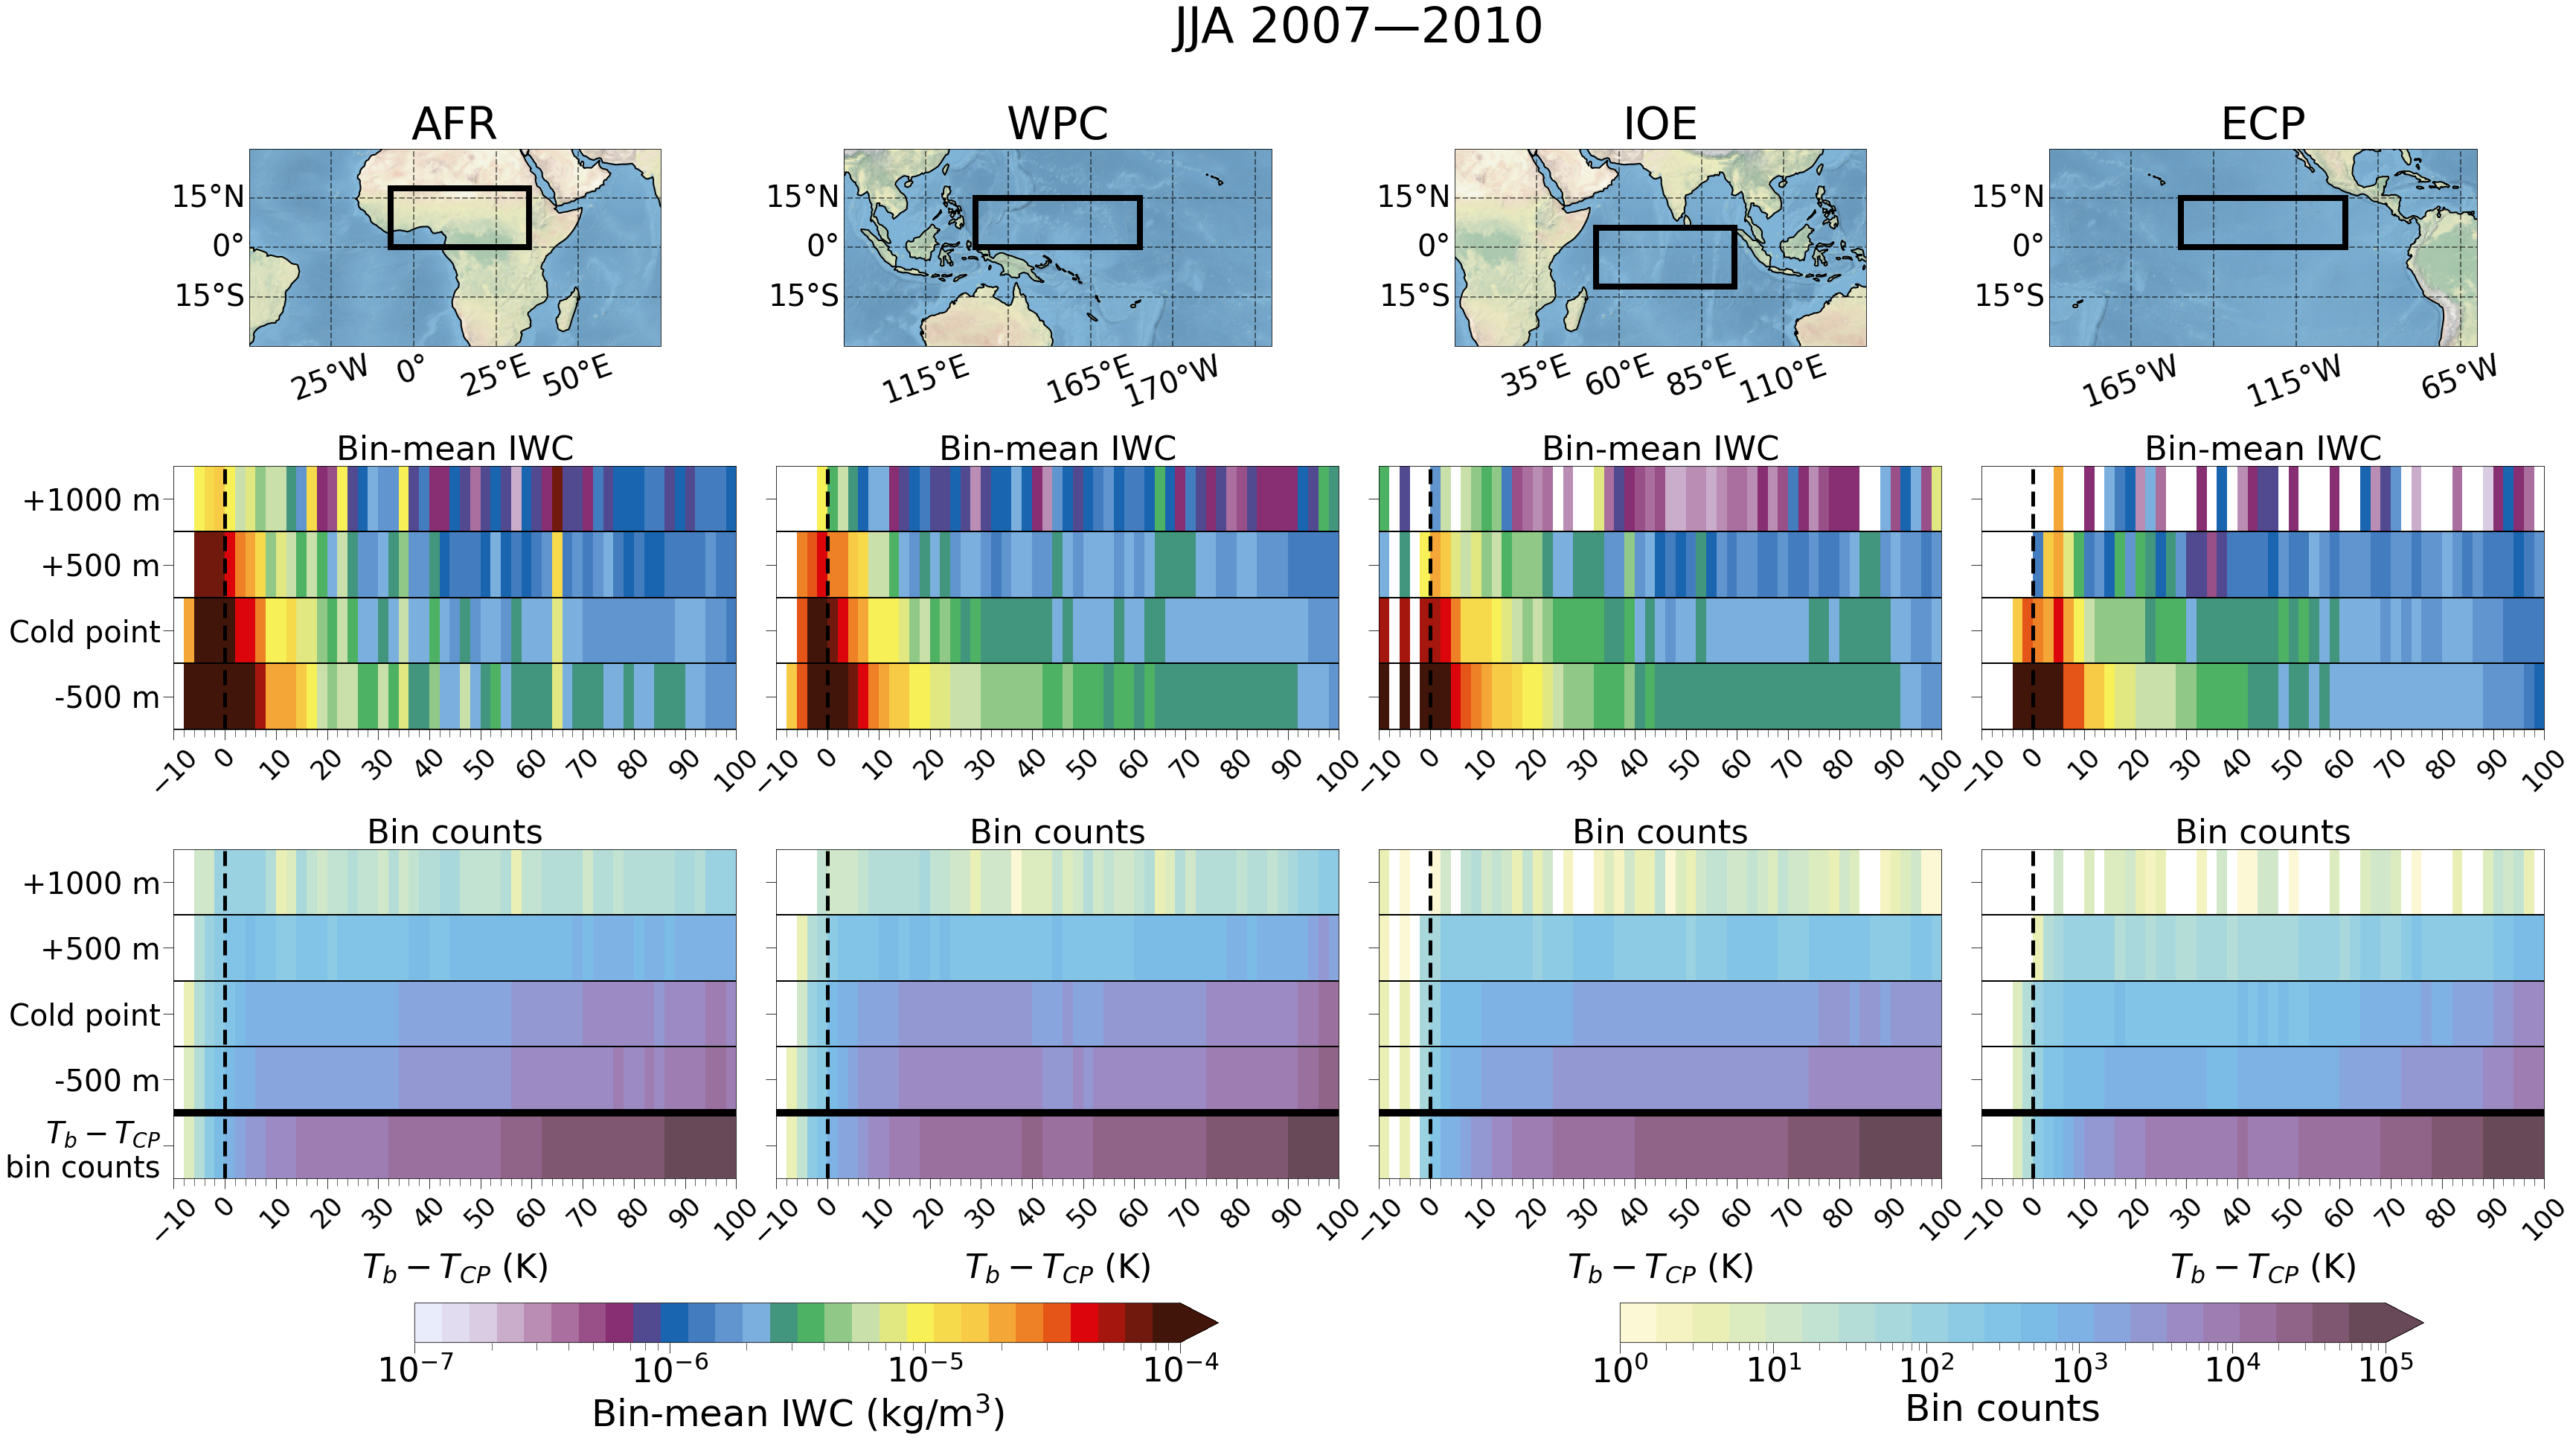

In [26]:
# JJA (SI)
bin_qi_season(iwc_means_dict_jja, iwc_counts_dict_jja, region_diffs_counts_dict_jja, "JJA", years_str, diffs_bins, 
              bin_iwc=True, mean_lims=iwc_lims,
              fsize=fsize, tsize=tsize, labsize=labsize, figsize=figsize, diffs_count_lims=count_lims,
              diffs_lims=diffs_lims, count_cmap=count_cmap, mean_cmap=mean_cmap, 
              save=save_plots, save_dir=plot_save_dir, main_text=False, cmap_version="_11",
              count_norm=None, mean_norm=None, count_cbar_ticks=None)


### Just radar+lidar

In [17]:
# main text

iwc3_means_dict_main = {
    "AMZ": iwc3_means_dict_djf["AMZ"],
    "SPC": iwc3_means_dict_djf["SPC"],
    "AFR": iwc3_means_dict_jja["AFR"],
    "WPC": iwc3_means_dict_jja["WPC"],
}
iwc3_counts_dict_main = {
    "AMZ": iwc3_counts_dict_djf["AMZ"],
    "SPC": iwc3_counts_dict_djf["SPC"],
    "AFR": iwc3_counts_dict_jja["AFR"],
    "WPC": iwc3_counts_dict_jja["WPC"],
}
region_diffs_counts_dict_main = {
    "AMZ": region_diffs_counts_dict_djf["AMZ"],
    "SPC": region_diffs_counts_dict_djf["SPC"],
    "AFR": region_diffs_counts_dict_jja["AFR"],
    "WPC": region_diffs_counts_dict_jja["WPC"],
}

# supporting info

iwc3_means_dict_si = {
    "IOS": iwc3_means_dict_djf["IOS"],
    "ECP": iwc3_means_dict_djf["ECP"],
    "IOE": iwc3_means_dict_jja["IOE"],
    "ECP2": iwc3_means_dict_jja["ECP"],
}
iwc3_counts_dict_si = {
    "IOS": iwc3_counts_dict_djf["IOS"],
    "ECP": iwc3_counts_dict_djf["ECP"],
    "IOE": iwc3_counts_dict_jja["IOE"],
    "ECP2": iwc3_counts_dict_jja["ECP"],
}
region_diffs_counts_dict_si = {
    "IOS": region_diffs_counts_dict_djf["IOS"],
    "ECP": region_diffs_counts_dict_djf["ECP"],
    "IOE": region_diffs_counts_dict_jja["IOE"],
    "ECP2": region_diffs_counts_dict_jja["ECP"],
}

### New version

Same as above

saved to /home/b/b380887/cold-point-overshoot/plots/obs_paper/paper_figs/IWC_binned_by_Tb-Tcp_both_instr__main_text_11.png


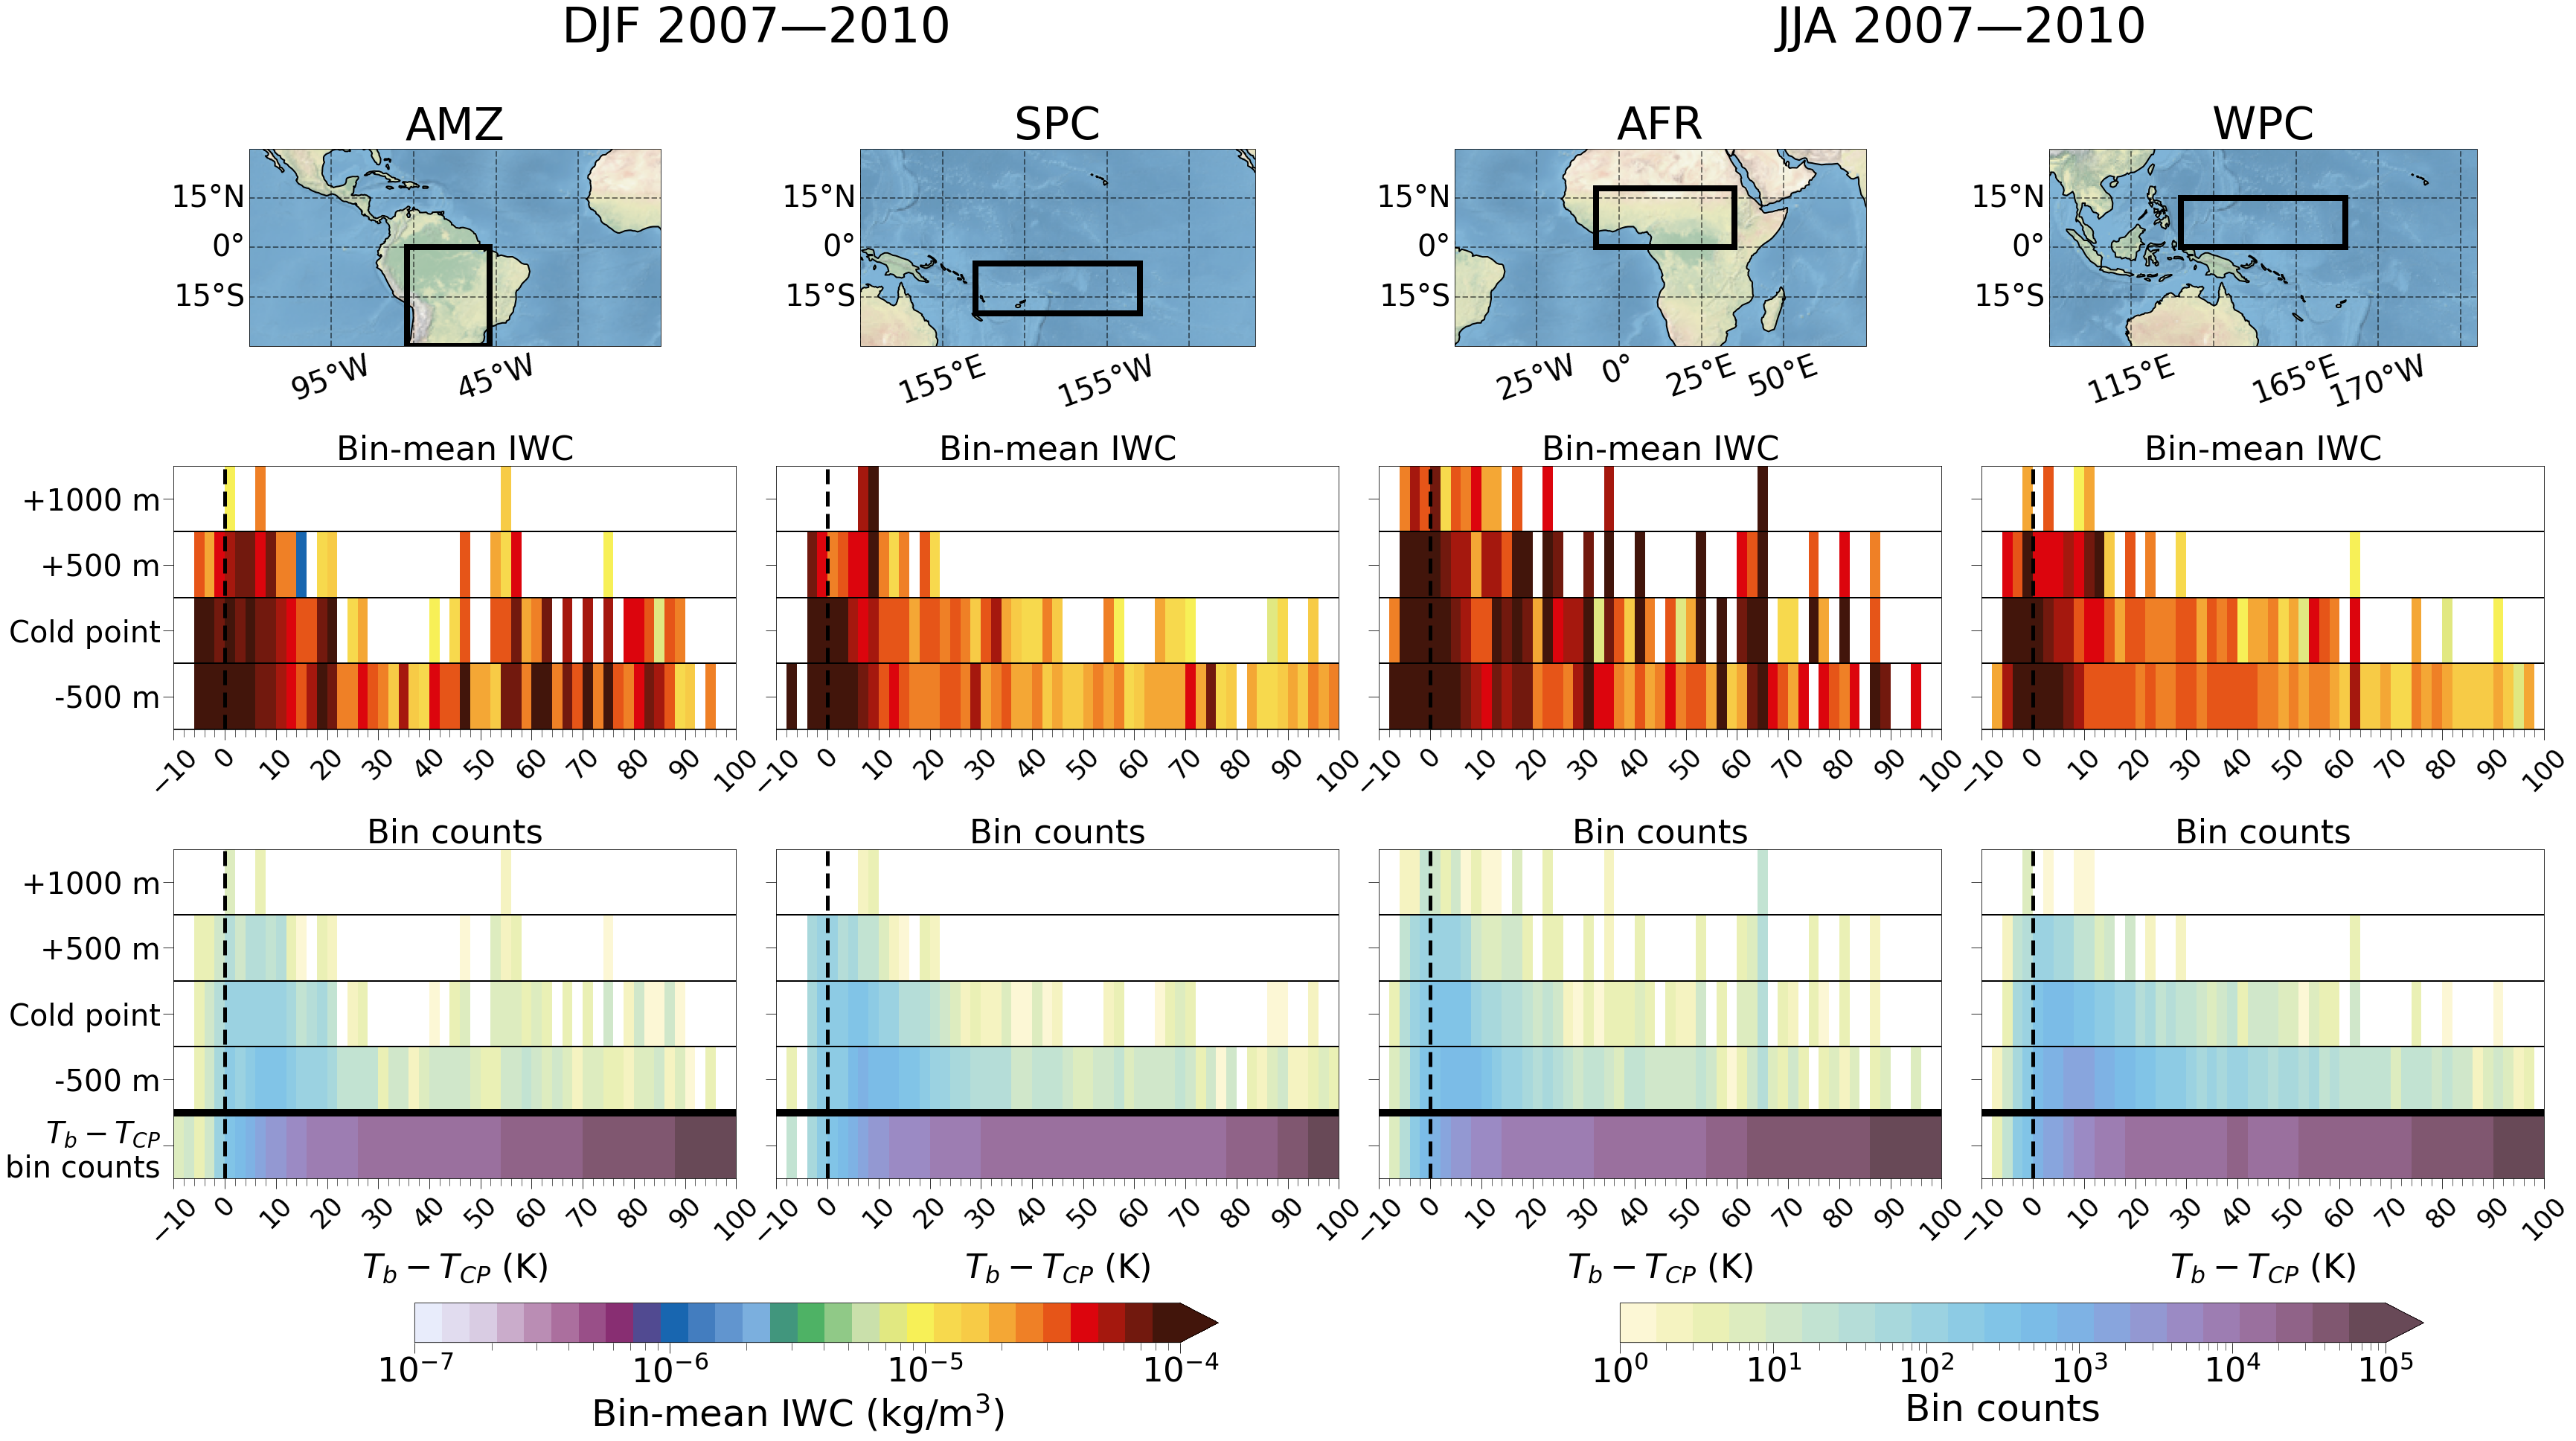

In [18]:
bin_qi_season(iwc3_means_dict_main, iwc3_counts_dict_main, region_diffs_counts_dict_main, ["DJF", "JJA"], years_str, diffs_bins, 
              bin_iwc=True, mean_lims=iwc_lims,
              fsize=fsize, tsize=tsize, labsize=labsize, figsize=figsize, diffs_count_lims=count_lims,
              diffs_lims=diffs_lims, count_cmap=count_cmap, mean_cmap=mean_cmap, cmap_version="_11",
              save=save_plots, save_dir=plot_save_dir, main_text=True,
                count_norm=None, mean_norm=None, count_cbar_ticks=None)


saved to /home/b/b380887/cold-point-overshoot/plots/obs_paper/paper_figs/IWC_binned_by_Tb-Tcp_both_instr__SI_11.png


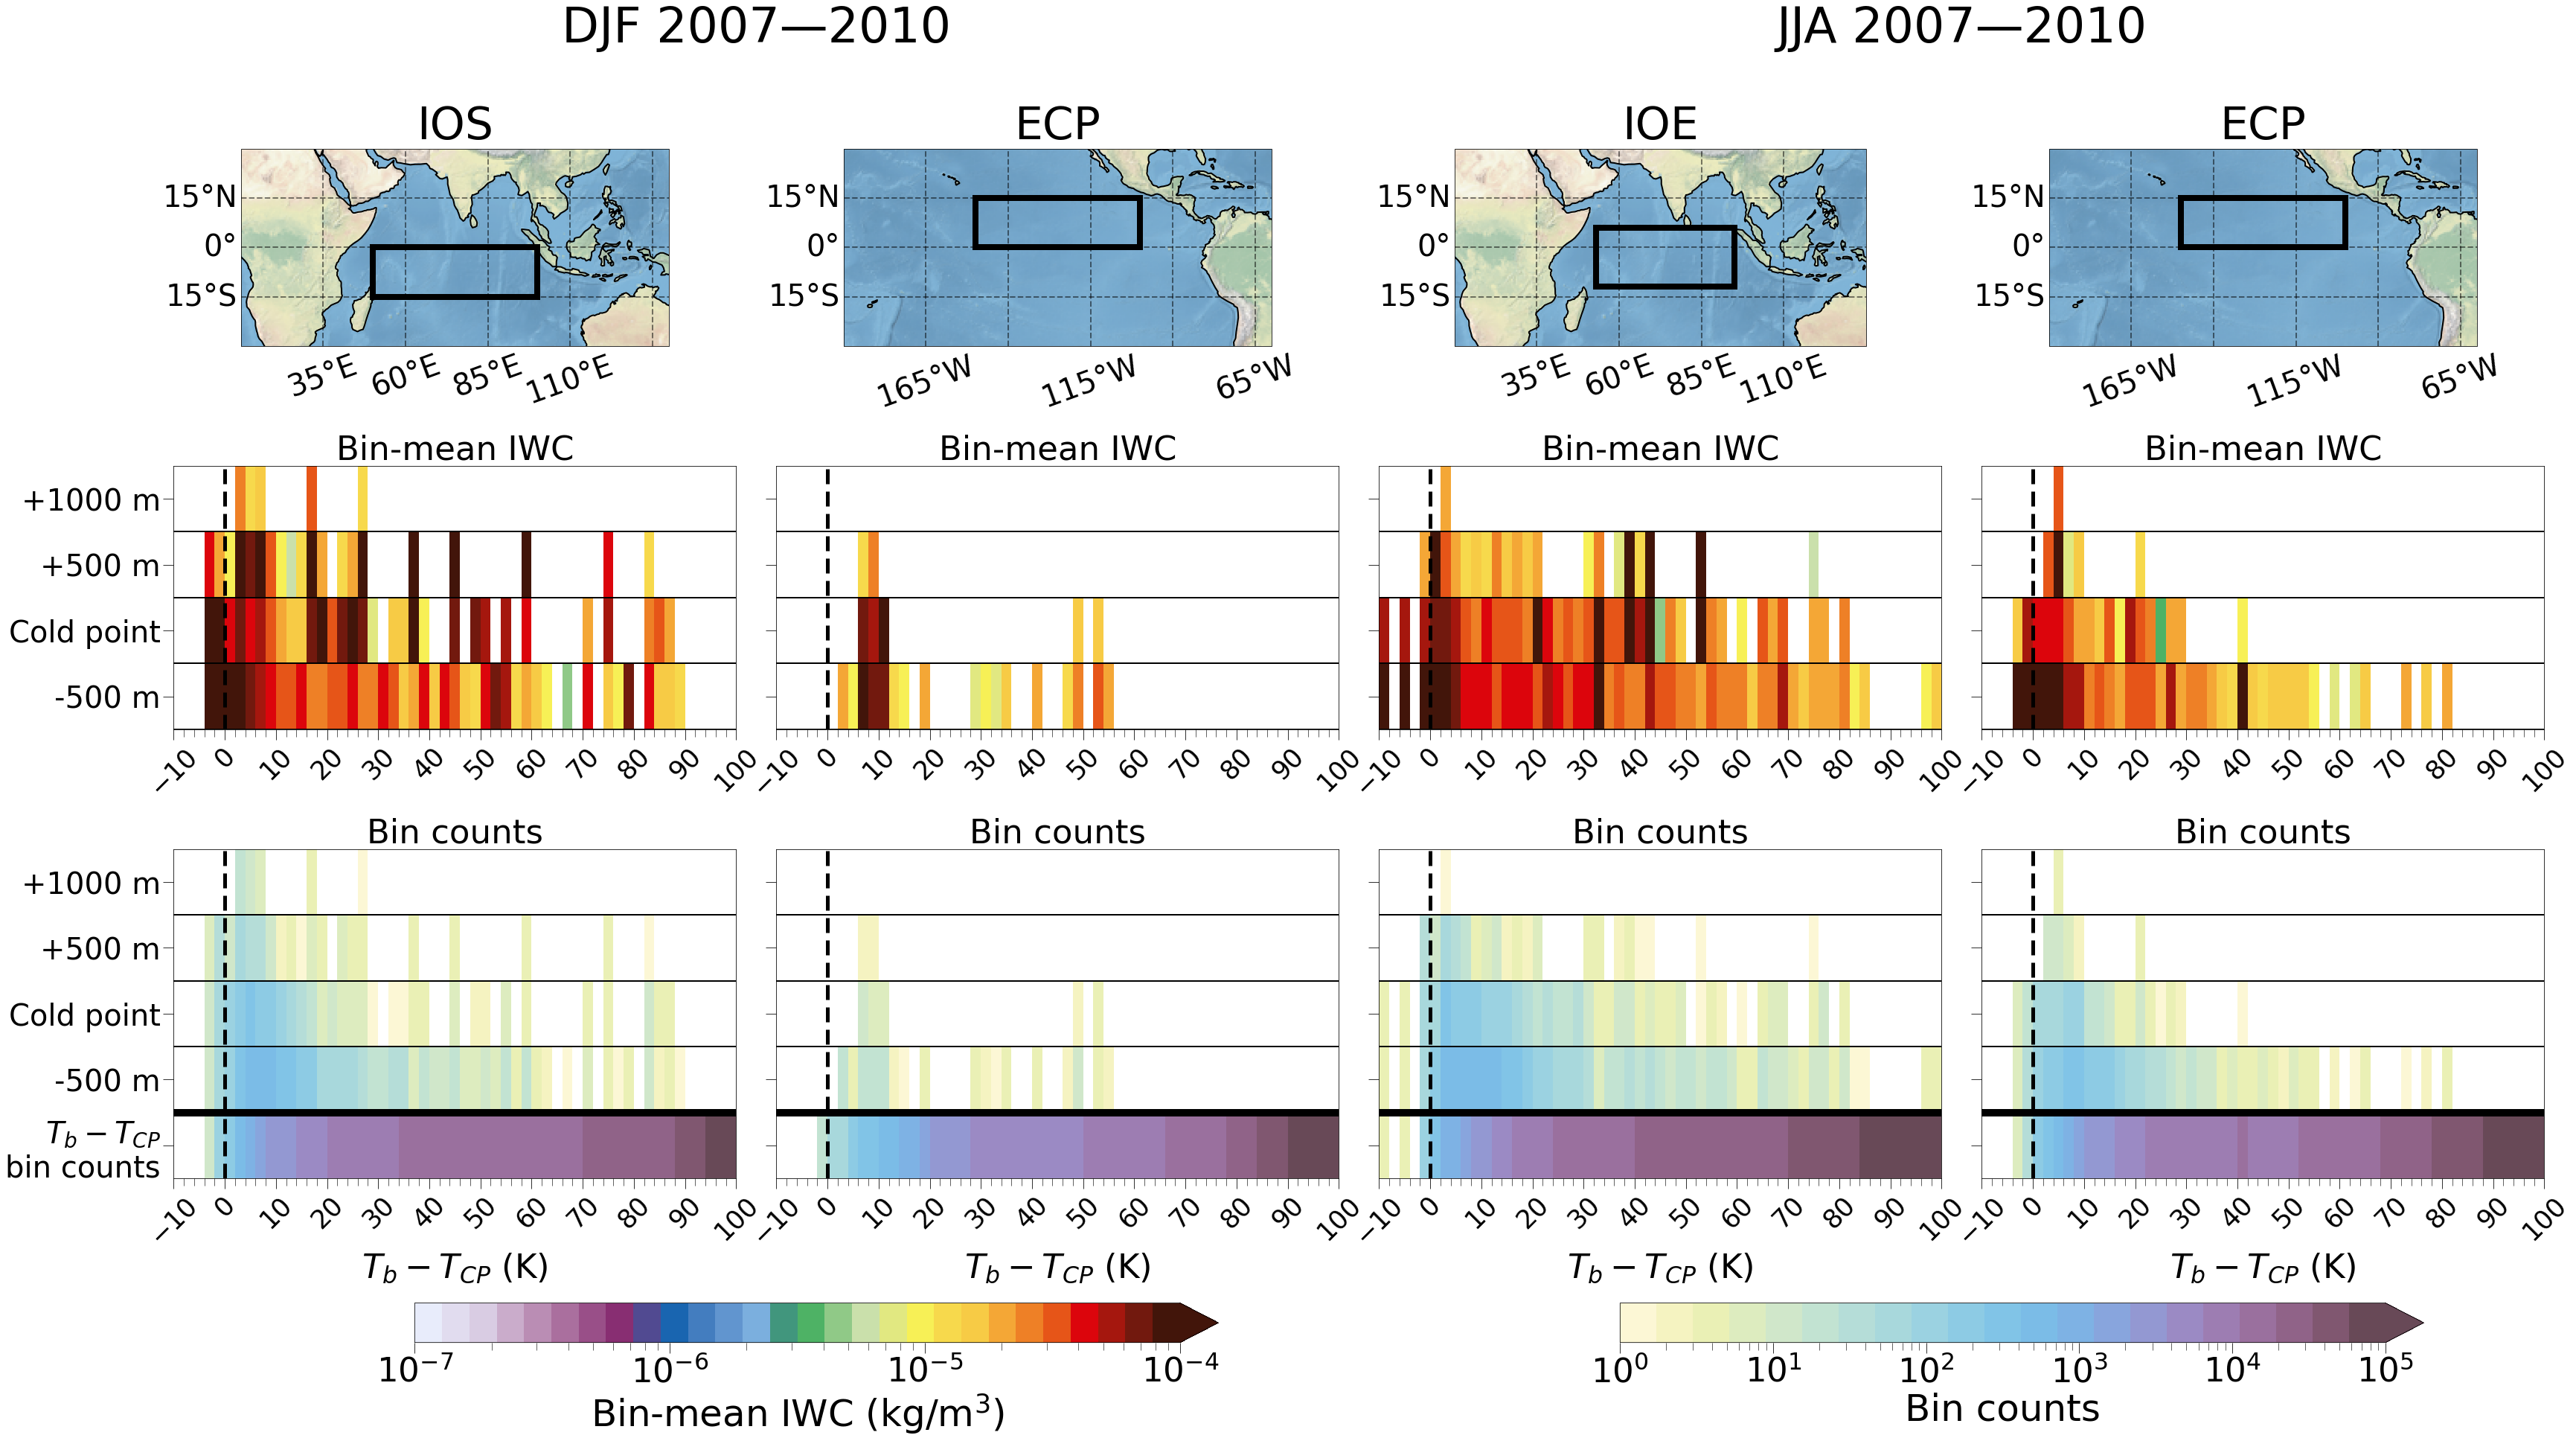

In [31]:
# SI
bin_qi_season(iwc3_means_dict_si, iwc3_counts_dict_si, region_diffs_counts_dict_si, ["DJF", "JJA"], years_str, diffs_bins, 
              bin_iwc=True, mean_lims=iwc_lims,
              fsize=fsize, tsize=tsize, labsize=labsize, figsize=figsize, diffs_count_lims=count_lims,
              diffs_lims=diffs_lims, count_cmap=count_cmap, mean_cmap=mean_cmap, cmap_version="_11",
              save=save_plots, save_dir=plot_save_dir, main_text=False,
                count_norm=None, mean_norm=None, count_cbar_ticks=None,
             mean_cbar_ticks=None)
